A canonical way of importing the `bulbea` module is as follows:

In [1]:
import bulbea as bb

In [2]:
from coinmarketcap_draw import coinmarketcap_data

Go ahead and create a `Share` object as follows:

In [3]:
coin_name = 'raiden-network-token'
data = coinmarketcap_data(coin_name)

In [4]:
nsamples = 10
data.tail(nsamples)

,market_cap,price_btc,price_usd,volume_usd,volume_token,Close
2017-12-05 17:49:00,167220624.0,0.000284,3.33448,15615900.0,4.683159e+06,3.33448
2017-12-05 18:04:00,165930793.0,0.000283,3.30876,15450100.0,4.669453e+06,3.30876
2017-12-05 18:19:00,166883623.0,0.000283,3.32776,15441800.0,4.640299e+06,3.32776
2017-12-05 18:34:00,169589659.0,0.000289,3.38172,15720900.0,4.648788e+06,3.38172
2017-12-05 18:49:00,172390477.0,0.000293,3.43757,15820900.0,4.602350e+06,3.43757
2017-12-05 19:04:00,172602106.0,0.000294,3.44179,15863400.0,4.609055e+06,3.44179
2017-12-05 19:19:00,174032354.0,0.000295,3.47031,15963300.0,4.599964e+06,3.47031
2017-12-05 19:34:00,171453695.0,0.000291,3.41889,15730300.0,4.600996e+06,3.41889
2017-12-05 19:49:00,169028493.0,0.000286,3.37053,15376100.0,4.561923e+06,3.37053
2017-12-05 19:54:00,168867515.0,0.000286,3.36732,15378400.0,4.566955e+06,3.36732


In order to analyse a given attribute, you could plot the same as follows:

##  Convert the data to hourly

In [25]:
from datetime import timedelta
import pandas as pd

def convert_with_n_hour_gap(data,n):
    times = data.index.copy()
    first_time = times[0].to_datetime()
    v_dict = dict()
    
    for x in range(1,len(times)):
        t = times[x].to_datetime()
        if n == 24:
            success = t.day == first_time.day + 1
        else:
            success = (first_time + timedelta(hours=n)).hour == t.hour
        if success:
            first_time = t
            index = pd.Timestamp(t)
            v_dict[index] = data.loc[index]['Close']
    df = pd.DataFrame(list(v_dict.items()), columns=['Date', 'Close'])
    df.set_index("Date",inplace=True)
    return df

In [26]:
share_array = []
for i in range(1,2):
    df = convert_with_n_hour_gap(data,i)
    share = bb.Share("123",'123',data=df)
    share_array.append(share)

/Users/geleichen/Desktop/NewBillions/bloomberg_crypto/lstm_research/gelei_bulbea/bulbea/entity/share.py:174: UserWarning: Environment variable BULBEA_QUANDL_API_KEY for Quandl hasn't been set. A maximum of 50000 calls per day can be made. Visit https://www.quandl.com to get your API key.
  warnings.warn(message)


## visualize the 24 hour data

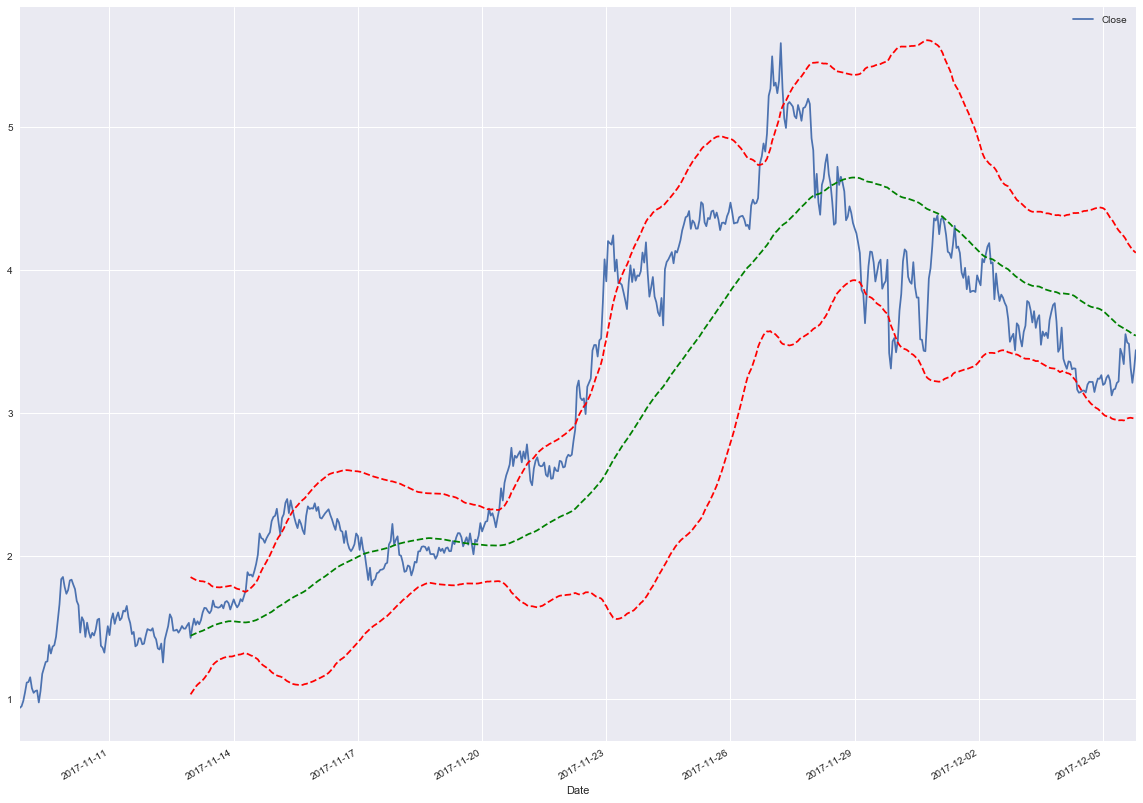

In [27]:
% matplotlib inline
share_array[-1].plot(['Close'], figsize = (20, 15), bollinger_bands = True, period = 100, bandwidth = 2)

## visualize the 1 hour data

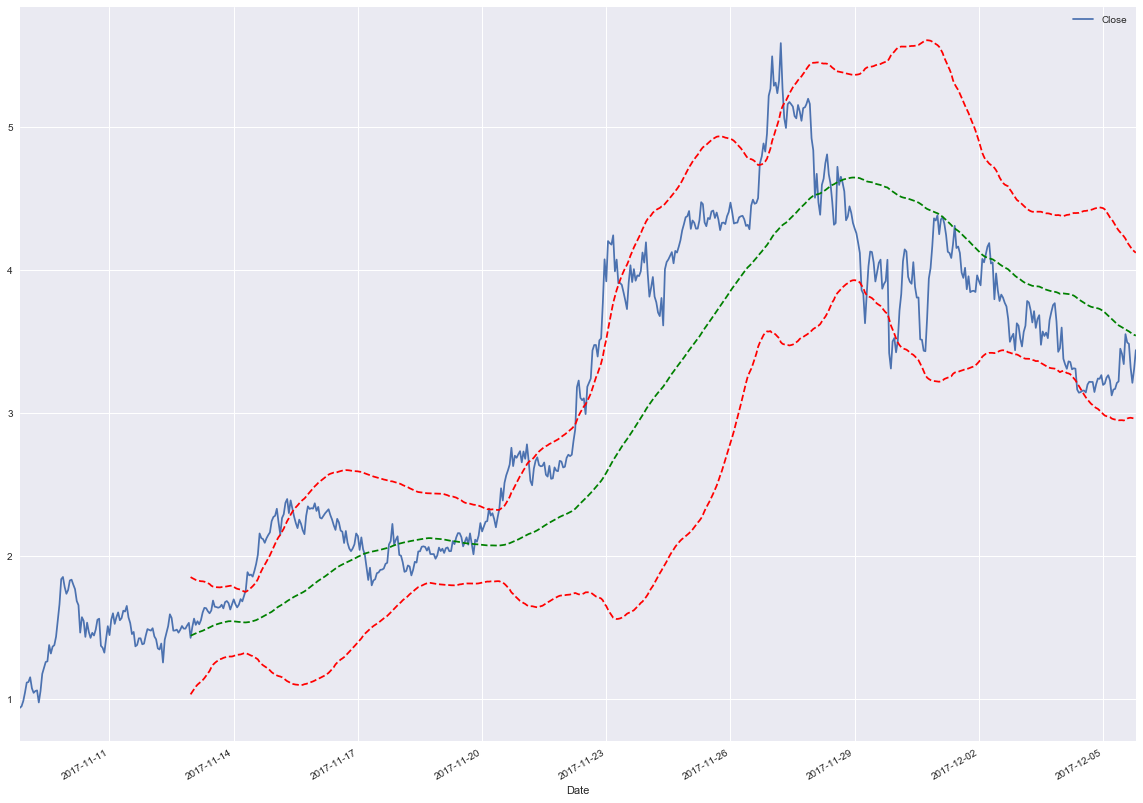

In [28]:
% matplotlib inline
share_array[0].plot(['Close'], figsize = (20, 15), bollinger_bands = True, period = 100, bandwidth = 2)

### Modelling

In [29]:
from bulbea.learn.models import RNN

### Training & Testing

In [30]:
from bulbea.learn.evaluation import split
import numpy as np

In [31]:
rnn_arr = []
for index,share in enumerate(share_array):
    print("{} hour. {}".format(index+1,len(share.data)))
    print(share.data.tail(5))
    Xtrain, Xtest, ytrain, ytest = split(share, 'Close', normalize = True)
    Xtrain  = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], 1))
    Xtest  = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], 1))
    
    # Training
    rnn = RNN([1, 100, 100, 1]) # number of neurons in each layer
    rnn.fit(Xtrain, ytrain)
    rnn_arr.append(rnn)
    

1 hour. 648
                       Close
Date                        
2017-12-05 15:04:00  3.48594
2017-12-05 16:04:00  3.31950
2017-12-05 17:04:00  3.21329
2017-12-05 18:04:00  3.30876
2017-12-05 19:04:00  3.44179
6 642


/Users/geleichen/Desktop/NewBillions/bloomberg_crypto/lstm_research/gelei_bulbea/bulbea/learn/models/ann.py:29: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  return_sequences = True
/Users/geleichen/Desktop/NewBillions/bloomberg_crypto/lstm_research/gelei_bulbea/bulbea/learn/models/ann.py:29: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=100)`
  return_sequences = True
/Users/geleichen/Desktop/NewBillions/bloomberg_crypto/lstm_research/gelei_bulbea/bulbea/learn/models/ann.py:36: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  self.model.add(core.Dense(output_dim = sizes[-1]))


Epoch 1/10
385/385 [==============================] - 6s - loss: 0.0046      
Epoch 2/10
385/385 [==============================] - 0s - loss: 0.0030     
Epoch 3/10
385/385 [==============================] - 0s - loss: 0.0028     

#### TESTING

1 hour. 648
                       Close
Date                        
2017-12-05 15:04:00  3.48594
2017-12-05 16:04:00  3.31950
2017-12-05 17:04:00  3.21329
2017-12-05 18:04:00  3.30876
2017-12-05 19:04:00  3.44179
6 642
0.0965942874206
6 642
4.34869
[5.6604861523142462]


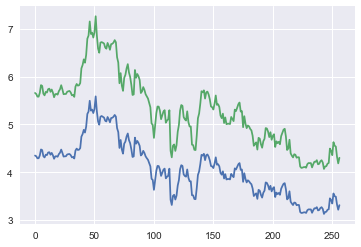

2 hour. 324
                       Close
Date                        
2017-12-05 11:04:00  3.41525
2017-12-05 13:04:00  3.55377
2017-12-05 15:04:00  3.48594
2017-12-05 17:04:00  3.21329
2017-12-05 19:04:00  3.44179
3 321
0.0249082465587
3 321
4.33332
[4.9612128122931711]


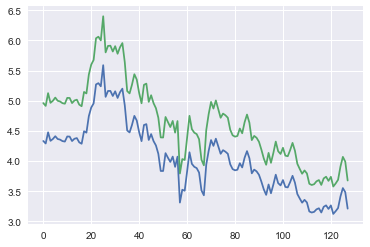

3 hour. 216
                       Close
Date                        
2017-12-05 07:04:00  3.17106
2017-12-05 10:04:00  3.45203
2017-12-05 13:04:00  3.55377
2017-12-05 16:04:00  3.31950
2017-12-05 19:04:00  3.44179
2 214
0.00933376469621
2 214
4.29013
[4.630825659791828]


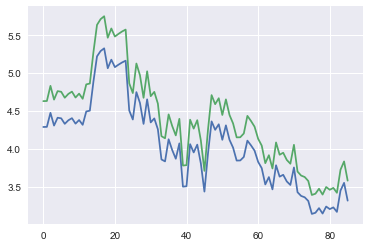

4 hour. 162
                       Close
Date                        
2017-12-05 03:04:00  3.26664
2017-12-05 07:04:00  3.17106
2017-12-05 11:04:00  3.41525
2017-12-05 15:04:00  3.48594
2017-12-05 19:04:00  3.44179
2 160
0.00907541192846
2 160
4.33332
[4.6774455431628219]


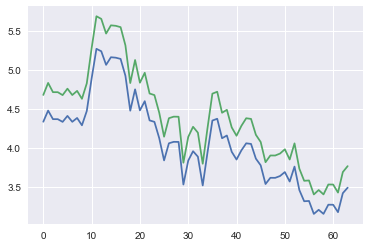

5 hour. 129
                       Close
Date                        
2017-12-04 20:04:00  3.20378
2017-12-05 01:04:00  3.20787
2017-12-05 06:04:00  3.16589
2017-12-05 11:04:00  3.41525
2017-12-05 16:04:00  3.31950
2 127
0.0111576629538
2 127
4.29013
[4.630825659791828]


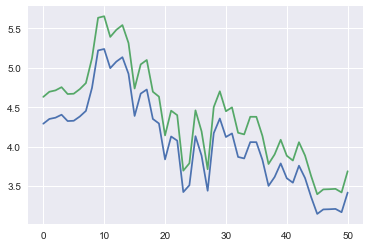

6 hour. 108
                       Close
Date                        
2017-12-04 19:04:00  3.14918
2017-12-05 01:04:00  3.20787
2017-12-05 07:04:00  3.17106
2017-12-05 13:04:00  3.55377
2017-12-05 19:04:00  3.44179
2 106
0.010332747288
2 106
4.47665
[4.8321579275935891]


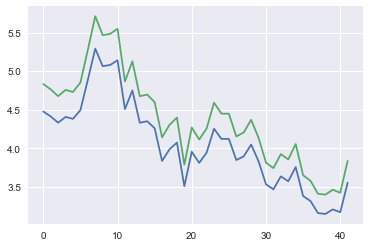

7 hour. 92
                       Close
Date                        
2017-12-04 11:04:00  3.14864
2017-12-04 18:04:00  3.21956
2017-12-05 01:04:00  3.20787
2017-12-05 08:04:00  3.21225
2017-12-05 15:04:00  3.48594
2 90
0.0123736611619
2 90
4.33332
[4.6774455431628219]


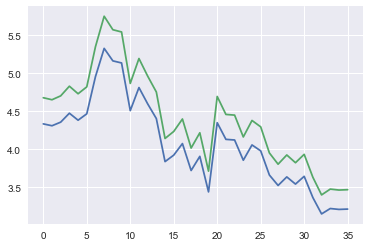

8 hour. 81
                       Close
Date                        
2017-12-04 11:04:00  3.14864
2017-12-04 19:04:00  3.14918
2017-12-05 03:04:00  3.26664
2017-12-05 11:04:00  3.41525
2017-12-05 19:04:00  3.44179
2 79
0.0103345135712
2 79
4.33332
[4.6774455431628219]


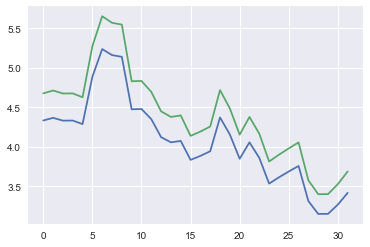

9 hour. 72
                       Close
Date                        
2017-12-04 07:04:00  3.31522
2017-12-04 16:04:00  3.22066
2017-12-05 01:04:00  3.20787
2017-12-05 10:04:00  3.45203
2017-12-05 19:04:00  3.44179
2 70
0.0110879487029
2 70
4.47665
[4.8321579275935891]


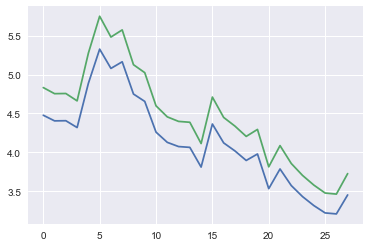

10 hour. 64
                       Close
Date                        
2017-12-03 19:04:00  3.75679
2017-12-04 05:04:00  3.35879
2017-12-04 15:04:00  3.20143
2017-12-05 01:04:00  3.20787
2017-12-05 11:04:00  3.41525
2 62
0.0119414778658
2 62
4.29013
[4.630825659791828]


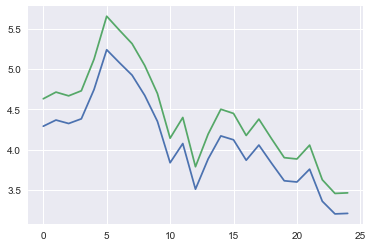

11 hour. 58
                       Close
Date                        
2017-12-03 13:04:00  3.57218
2017-12-04 00:04:00  3.59993
2017-12-04 11:04:00  3.14864
2017-12-04 22:04:00  3.24155
2017-12-05 09:04:00  3.22322
2 56
0.0149166607371
2 56
4.47665
[4.8321579275935891]


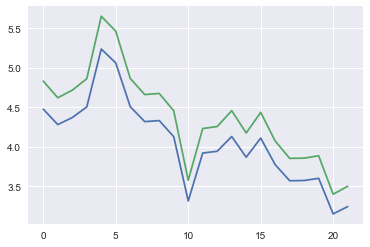

12 hour. 54
                       Close
Date                        
2017-12-03 19:04:00  3.75679
2017-12-04 07:04:00  3.31522
2017-12-04 19:04:00  3.14918
2017-12-05 07:04:00  3.17106
2017-12-05 19:04:00  3.44179
2 52
0.0126131247511
2 52
4.47665
[4.8321579275935891]


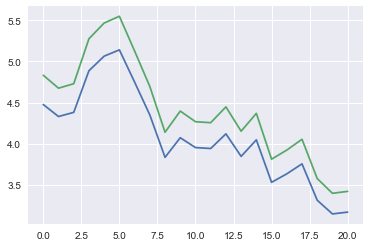

13 hour. 49
                       Close
Date                        
2017-12-03 04:04:00  3.78558
2017-12-03 17:04:00  3.65259
2017-12-04 06:04:00  3.30780
2017-12-04 19:04:00  3.14918
2017-12-05 08:04:00  3.21225
2 47
0.0161628860061
2 47
4.29013
[4.630825659791828]


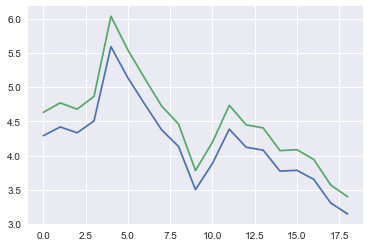

14 hour. 46
                       Close
Date                        
2017-12-03 07:04:00  3.63552
2017-12-03 21:04:00  3.64327
2017-12-04 11:04:00  3.14864
2017-12-05 01:04:00  3.20787
2017-12-05 15:04:00  3.48594
2 44
0.0143714877853
2 44
4.33332
[4.6774455431628219]


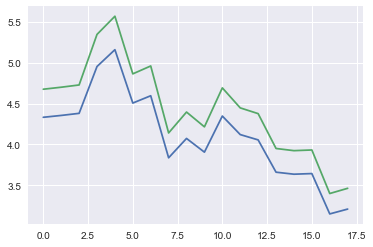

15 hour. 43
                       Close
Date                        
2017-12-03 04:04:00  3.78558
2017-12-03 19:04:00  3.75679
2017-12-04 10:04:00  3.14431
2017-12-05 01:04:00  3.20787
2017-12-05 16:04:00  3.31950
2 41
0.0180115714618
2 41
4.40427
[4.7540299544888738]


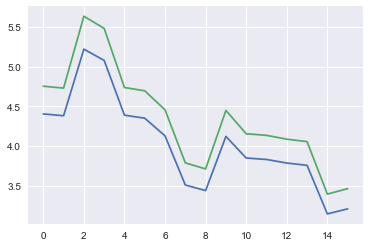

16 hour. 40
                       Close
Date                        
2017-12-02 19:04:00  3.53282
2017-12-03 11:04:00  3.68646
2017-12-04 03:04:00  3.31144
2017-12-04 19:04:00  3.14918
2017-12-05 11:04:00  3.41525
2 38
0.0144417243894
2 38
4.36658
[4.7133468471896647]


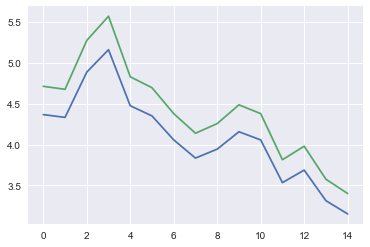

17 hour. 38
                       Close
Date                        
2017-12-02 21:04:00  3.44116
2017-12-03 14:04:00  3.54108
2017-12-04 07:04:00  3.31522
2017-12-05 00:04:00  3.19882
2017-12-05 17:04:00  3.21329
2 36
0.0208825466076
2 36
4.33152
[4.6755025982666014]


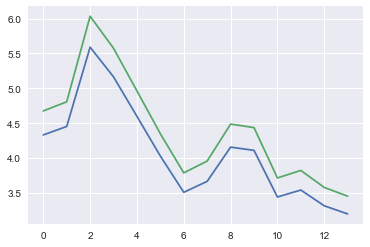

18 hour. 36
                       Close
Date                        
2017-12-02 19:04:00  3.53282
2017-12-03 13:04:00  3.57218
2017-12-04 07:04:00  3.31522
2017-12-05 01:04:00  3.20787
2017-12-05 19:04:00  3.44179
2 34
0.0135415350701
2 34
4.47665
[4.8321579275935891]


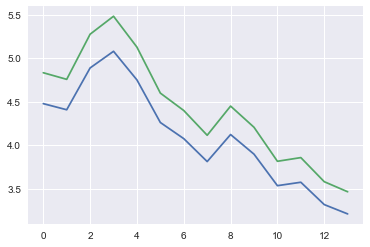

19 hour. 34
                       Close
Date                        
2017-12-02 13:04:00  3.83038
2017-12-03 08:04:00  3.71471
2017-12-04 03:04:00  3.31144
2017-12-04 22:04:00  3.24155
2017-12-05 17:04:00  3.21329
2 32
0.0178918620889
2 32
4.30872
[4.6508919629144669]


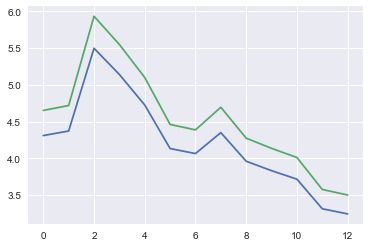

20 hour. 32
                       Close
Date                        
2017-12-02 03:04:00  4.05610
2017-12-02 23:04:00  3.61281
2017-12-03 19:04:00  3.75679
2017-12-04 15:04:00  3.20143
2017-12-05 11:04:00  3.41525
2 30
0.0176368992695
2 30
4.36658
[4.7133468471896647]


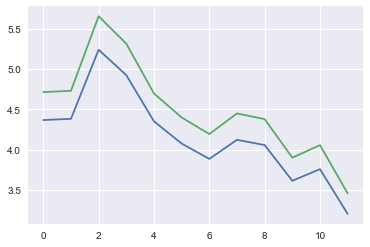

21 hour. 30
                       Close
Date                        
2017-12-01 13:04:00  4.12131
2017-12-02 10:04:00  3.97830
2017-12-03 07:04:00  3.63552
2017-12-04 04:04:00  3.36358
2017-12-05 01:04:00  3.20787
2 28
0.0223451608341
2 28
4.30872
[4.6508919629144669]


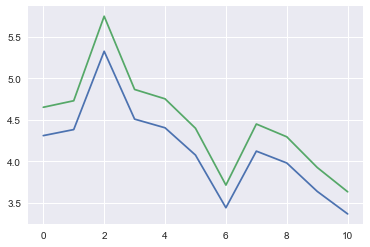

22 hour. 29
                       Close
Date                        
2017-12-01 17:04:00  3.86784
2017-12-02 15:04:00  3.77302
2017-12-03 13:04:00  3.57218
2017-12-04 11:04:00  3.14864
2017-12-05 09:04:00  3.22322
2 27
0.0273312133703
2 27
4.47665
[4.8321579275935891]


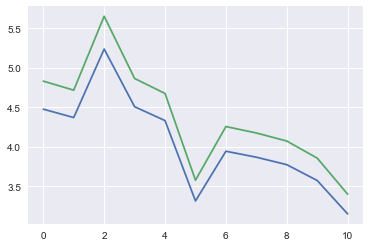

23 hour. 28
                       Close
Date                        
2017-12-01 19:04:00  3.84757
2017-12-02 18:04:00  3.50026
2017-12-03 17:04:00  3.65259
2017-12-04 16:04:00  3.22066
2017-12-05 15:04:00  3.48594
2 26
0.0309082498346
2 26
4.40625
[4.7561671938747168]


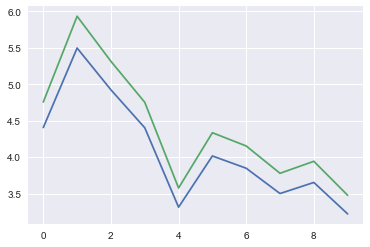

24 hour. 22
                       Close
Date                        
2017-11-26 00:04:00  4.47376
2017-11-27 00:14:00  5.49705
2017-11-28 00:04:00  4.83985
2017-11-29 00:04:00  4.29294
2017-11-30 00:04:00  3.42678
2 20
0.0367356740261
2 20
2.62656
[2.8351451925659181]


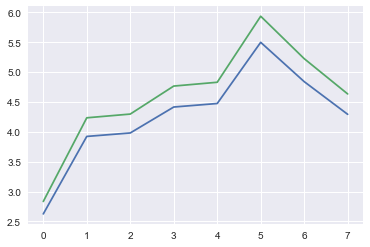

In [24]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as pplt
from bulbea.entity.share import _reverse_cummulative_return
from datetime import datetime

for index,share in enumerate(share_array):
    print("{} hour. {}".format(index+1,len(share.data)))
    print(share.data.tail(5))
    _, Xtest, _, ytest = split(share, 'Close', normalize = True)
    Xtest  = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], 1))

    predicted = rnn.predict(Xtest)
    sqr_err = mean_squared_error(ytest, predicted)
    print(sqr_err)
    
    
    _,_,_,ori_ytest = split(share, 'Close', normalize = False)
    
    new_pre = []
    for x in range(0,len(ori_ytest)):
        t = ori_ytest[x]
        predict = predicted[x]
        new_pre.append(_reverse_cummulative_return(t,predict))

    pplt.plot(ori_ytest)
    pplt.plot(new_pre)
    print(ori_ytest[0])
    print(new_pre[0])
    pplt.show()

    rnn.model.save("models/{}_{}.h5".format(coin_name,index+1))